<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">
</center>

<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [ ]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 
# !unzip -q Positive_tensors.zip 

In [ ]:
# ! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
# !unzip -q Negative_tensors.zip

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [1]:
# These are the libraries will be used for this lab.
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import os
import zipfile
import glob
import time

from typing import Tuple,List,Dict,Union, Any

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [2]:
# Create your own dataset object

class Data(Dataset):
    # Constructor
    def __init__(self,transform = None,train:bool = True):
        directory = os.path.join(os.getcwd(),'..','images')
        positive = 'Positive'
        negative = 'Negative'

        # Paths and files
        positive_path = os.path.join(directory, positive)
        negative_path = os.path.join(directory, negative)
        positive_files = [os.path.join(positive_path,file) for file in  os.listdir(positive_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_path,file) for file in  os.listdir(negative_path) if file.endswith(".jpg")]
        negative_files.sort()

        self.number_of_samples = len(positive_files) + len(negative_files)

        # Atrributes
        self.all_files = [None]*self.number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        # The transform is going to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y = torch.zeros([self.number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0

        if train:
            self.all_files=self.all_files[0:30_000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:30_000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx:int):
        image = Image.open(self.all_files[idx])
        y = self.Y[idx]
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)
        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [4]:
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

composed = transforms.Compose([transforms.Resize(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

In [5]:
train_dataset = Data(transform = composed, train=True)
validation_dataset = Data(transform = composed,train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [6]:
# Step 1: Load the pre-trained model resnet18
model = models.resnet18(pretrained = True)

c:\Users\DELL\PythonProjects\AICapstone\venvai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DELL\PythonProjects\AICapstone\venvai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [7]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [8]:
print(model.fc,'\n')

# Change model final layer to fit the 2 classes
model.fc = nn.Linear(512,2)

print('New model final layer for classification:') 
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True) 

New model final layer for classification:
Linear(in_features=512, out_features=2, bias=True)


Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [10]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [11]:
train_loader = DataLoader(train_dataset,batch_size=100)
validation_loader = DataLoader(validation_dataset,batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [12]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [13]:
# Parameters to initialize 
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)


start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:
        model.train() 
        optimizer.zero_grad()
        z = model(x) 
        loss = criterion(z,y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    correct=0
    for x_test, y_test in validation_loader:
        model.eval() 
        yhat = model(x)
        _,label = torch.max(yhat,1)
        correct += (label==y).sum().item()
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

final_time = time.time()
abs_time = final_time - start_time  

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [51]:
torch.save(model,'saved_models/newresnet.pt')

In [52]:
accuracy

0.94

The time of the run of the code is of `(minutes,seconds)`

In [80]:
import math
math.floor(-abs_time/60), (-abs_time/60-math.floor(-abs_time/60))*60

(48, 17.397854566574154)

Plot of loss vs iterations

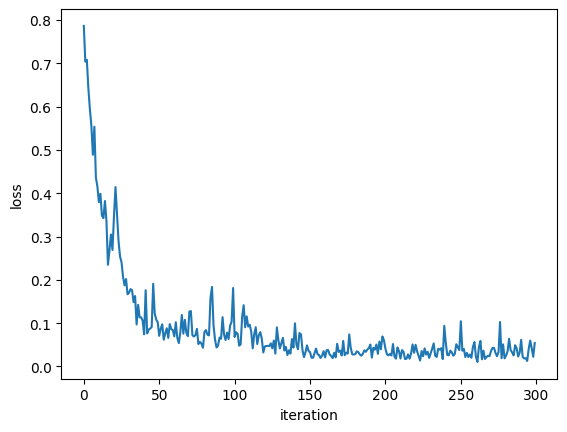

In [30]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [48]:
def show_data(data_sample:torch.Tensor) -> Any:
    npimg = data_sample[0].numpy()
    npimg = np.transpose(npimg, (1,2,0))
    npimg = ((npimg * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406])
    plt.imshow(npimg, interpolation = 'nearest')
    plt.title('y = '+ str(data_sample[1].item()))

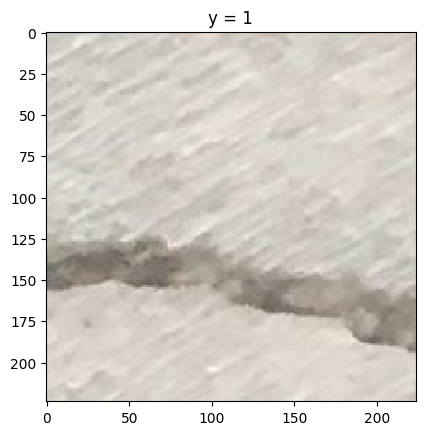

yhat:  tensor([0])


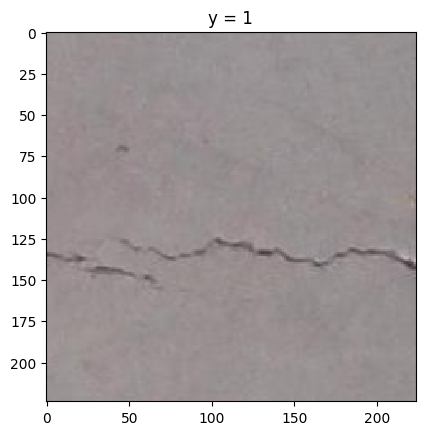

yhat:  tensor([0])


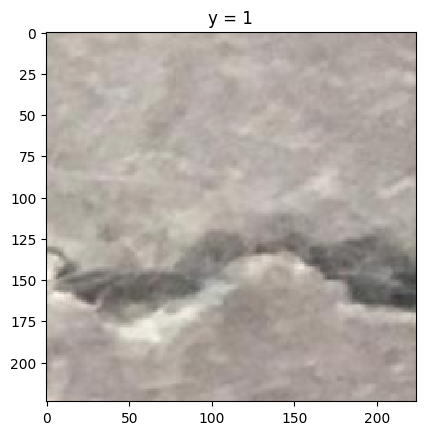

yhat:  tensor([0])


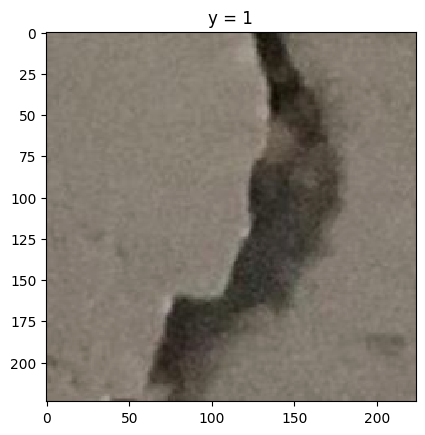

yhat:  tensor([0])


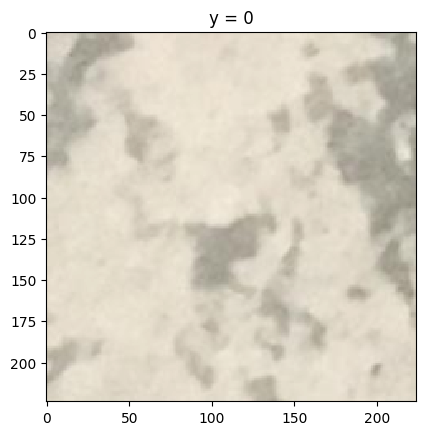

yhat:  tensor([1])


In [49]:
count = 0
for x, y in DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x[0], y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01&utm_medium=Exinfluencer&utm_term=10006555"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
